In [ ]:
!pip install sentence_transformers datasets

In [ ]:
%cd /content/drive/MyDrive/2023_spring_semester/TextMining/tm_teamproject

/content/drive/MyDrive/2023_spring_semester/TextMining/tm_teamproject


In [ ]:
import numpy as np
import pandas as pd
import math
import logging
from datetime import datetime
from pytz import timezone
import gc

import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, models, LoggingHandler, losses, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, BinaryClassificationEvaluator
from sentence_transformers.readers import InputExample
from sklearn.model_selection import train_test_split

In [ ]:
# log 정의
logger = logging.getLogger()
logger.setLevel(logging.INFO)
# log format 정의
formatter = logging.Formatter('%(asctime)s : %(message)s')
lh = LoggingHandler()
lh.setFormatter(formatter)
logger.handlers = [lh]

## 1. Load Dataset & Preprocessing

In [ ]:
import pandas as pd
train = pd.read_csv('/content/drive/MyDrive/2023_spring_semester/TextMining/tm_teamproject/TM_train_pp.csv')
train

,title,content,newsCategory,clickbaitClass,clickbaitTitle
0,"['윤리', '문제', '종근당', '회장', '조사', '마치', '귀가', '사죄']","['사죄', '운전기사', '허구', '날', '폭언', '퍼', '부어', '윤리...",경제,0,"['친환경', '금융', '목표', '탄소', '중립', '실천', '나선', '금..."
1,"['최종', '구', '금융', '위원장', '임팩트', '금융', '정착', '위...","['최종', '구', '금융', '위원회', '위원장', '임팩트', '금융', '...",경제,0,"['공동', '주택', '하자', '분쟁', '조정', '본격']"
2,"['한국', '기업', '지배구조', '개', '기업', '등급', '부여']","['한국', '기업', '지배구조', '월', '일', '국내', '상장회사', '...",경제,0,"['생활', '건강', '사상', '최대', '실적', '주가', '반등', '글쎄']"
3,"['가을', '더', '기업', '프로보노', '활동']","['요즘', '프로보노', '형', '사회', '공헌', '활동', '회사', '늘...",경제,0,"['로봇청소기', '강', '코오롱', '글로벌', '국내', '론칭']"
4,"['다우존스', '가능', '지수', '기업', '편입']","['런던', '현지', '시각', '일', '스탠다드', '앤', '어스', '다우...",경제,0,"['한숨', '유통업', '매출', '얼마나']"
...,...,...,...,...,...
291453,"['전국', '아난', '티', '객실', '부산', '세계박람회', '홍보', '...","['부산시', '아난', '티', '부산', '세계박람회', '유치', '열기', ...",사회,1,"['전국', '아난', '티', '객실', '부산', '세계박람회', '홍보', '..."
291454,"['부산시', '취약', '계층', '일자리', '창', '예비', '사회', '기...","['부산시', '년', '제', '차', '부산광역시', '예비', '사회', '기...",사회,1,"['부산시', '취약', '계층', '일자리', '창', '예비', '사회', '기..."
291455,"['코로나', '재', '유행', '신규', '명대', '일', '재', '진입']","['코로나', '신규', '확', '진자', '수가', '일', '명대', '다시'...",사회,1,"['코로나', '재', '유행', '신규', '명대', '일', '재', '진입']"
291456,"['산림청', '산림', '내', '불법행위', '집중', '단속', '월', '일...","['산림청', '본격', '여름', '휴가', '철', '월', '일', '월말',...",사회,1,"['산림청', '산림', '내', '불법행위', '집중', '단속', '월', '일..."


In [ ]:
train = train[['clickbaitTitle', 'content', 'clickbaitClass']]
train['clickbaitTitle'] = train['clickbaitTitle'].map(lambda x:x.replace('[', '').replace(']', '').replace('\'', '').replace(',', ''))
train['content'] = train['content'].map(lambda x:x.replace('[', '').replace(']', '').replace('\'', '').replace(',', ''))
train.shape

In [ ]:
train

,clickbaitTitle,content,clickbaitClass
0,친환경 금융 목표 탄소 중립 실천 나선 금융업,사죄 운전기사 허구 날 폭언 퍼 부어 윤리 문제 이장 종근당 회장 일 경찰 피의자 ...,0
1,공동 주택 하자 분쟁 조정 본격,최종 구 금융 위원회 위원장 임팩트 금융 사회 금융 의 안착 차원 정부 직접 기금 ...,0
2,생활 건강 사상 최대 실적 주가 반등 글쎄,한국 기업 지배구조 월 일 국내 상장회사 환경 경영 사회 책임 경영 지배구조 수준 ...,0
3,로봇청소기 강 코오롱 글로벌 국내 론칭,요즘 프로보노 형 사회 공헌 활동 회사 늘 회사 경영 거나 기업 일 능력 공익 차원...,0
4,한숨 유통업 매출 얼마나,런던 현지 시각 일 스탠다드 앤 어스 다우존스 인 디시 와 로베코샘 다우존스 가능 ...,0
...,...,...,...
291453,전국 아난 티 객실 부산 세계박람회 홍보 영상 상영,부산시 아난 티 부산 세계박람회 유치 열기 확산 위해 손 부산시 내달 부산 가평 남...,1
291454,부산시 취약 계층 일자리 창 예비 사회 기업 일자리 사업 공모,부산시 년 제 차 부산광역시 예비 사회 기업 일자 리창 사업 공모 고 일 이 사업 ...,1
291455,코로나 재 유행 신규 명대 일 재 진입,코로나 신규 확 진자 수가 일 명대 다시 것 정부 코로나 유행 감소 세 증가 세로 ...,1
291456,산림청 산림 내 불법행위 집중 단속 월 일 월말,산림청 본격 여름 휴가 철 월 일 월말 산림 사법 특별 대책 기간 정해 전국 산림 ...,1


In [ ]:
train['clickbaitClass'].value_counts()

0    146113
1    145345
Name: clickbaitClass, dtype: int64

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/2023_spring_semester/TextMining/tm_teamproject/valid_pp.csv')
df_test = df_test[['clickbaitTitle', 'content', 'clickbaitClass']]
df_test['clickbaitTitle'] = df_test['clickbaitTitle'].map(lambda x:x.replace('[', '').replace(']', '').replace('\'', '').replace(',', ''))
df_test['content'] = df_test['content'].map(lambda x:x.replace('[', '').replace(']', '').replace('\'', '').replace(',', ''))
df_test.shape

(36422, 3)

In [ ]:
df_train, df_val = train_test_split(train, test_size=0.2, random_state=2023)
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((233166, 3), (58292, 3), (36422, 3))

In [ ]:
def make_sts_input_example(dataset):
    # Transform to InputExample
    input_examples = []
    for i in range(len(dataset)):
        sentence1 = dataset.loc[i, 'clickbaitTitle']
        sentence2 = dataset.loc[i, 'content']
        label = dataset.loc[i, 'clickbaitClass']
        input_examples.append(InputExample(texts=[sentence1, sentence2], label=label))

    return input_examples

sts_train = make_sts_input_example(df_train)
sts_valid = make_sts_input_example(df_val)
sts_test = make_sts_input_example(df_test)

In [ ]:
sts_num_epochs = 5
train_batch_size = 128

In [ ]:
train_dataloader = DataLoader(
    sts_train,
    shuffle=True,
    batch_size=train_batch_size,
)

dev_evaluator = BinaryClassificationEvaluator.from_input_examples(
    sts_valid,
    name="sts-dev",
    show_progress_bar=True
)

test_evaluator = BinaryClassificationEvaluator.from_input_examples(
    sts_test,
    name="sts-test",
    show_progress_bar=True
)

# EmbeddingSimilarityEvaluator

## 2. Load Embedding Model

In [ ]:
pretrained_model_name = 'klue/roberta-base'
sts_model_save_path = '/content/drive/MyDrive/2023_spring_semester/TextMining/tm_teamproject/output/training_sts-'+pretrained_model_name.replace('/', '-')+'-'+datetime.now(timezone('Asia/Seoul')).strftime("%Y-%m-%d_%H-%M-%S")

In [ ]:
# Load Embedding Model
embedding_model = models.Transformer(
    model_name_or_path=pretrained_model_name,
    max_seq_length=128,
    do_lower_case=True
)

# Only use Mean Pooling -> Pooling all token embedding vectors of sentence.
pooling_model = models.Pooling(
    embedding_model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True,
    pooling_mode_cls_token=False,
    pooling_mode_max_tokens=False,
)

model = SentenceTransformer(modules=[embedding_model, pooling_model])

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

2023-06-05 07:54:10,932 : Use pytorch device: cuda


In [ ]:
torch.cuda.empty_cache()
gc.collect()

67

## 3. STS training

In [ ]:
# train_loss = losses.CosineSimilarityLoss(model=model)
train_loss = losses.ContrastiveLoss(model=model)

# warmup steps
warmup_steps = math.ceil(len(sts_train) * sts_num_epochs / train_batch_size * 0.1) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))

2023-06-05 07:54:20,213 : Warmup-steps: 911


In [ ]:
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=dev_evaluator,
    epochs=sts_num_epochs,
    evaluation_steps=int(len(train_dataloader)*0.1),
    warmup_steps=warmup_steps,
    output_path=sts_model_save_path
)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1822 [00:00<?, ?it/s]

2023-06-05 07:56:37,540 : Binary Accuracy Evaluation of the model on sts-dev dataset in epoch 0 after 182 steps:


Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 07:58:53,611 : Accuracy with Cosine-Similarity:           83.64	(Threshold: 0.7115)
2023-06-05 07:58:53,612 : F1 with Cosine-Similarity:                 85.33	(Threshold: 0.6891)
2023-06-05 07:58:53,612 : Precision with Cosine-Similarity:          76.82
2023-06-05 07:58:53,612 : Recall with Cosine-Similarity:             95.96
2023-06-05 07:58:53,613 : Average Precision with Cosine-Similarity:  82.74

2023-06-05 07:58:54,074 : Accuracy with Manhattan-Distance:           84.04	(Threshold: 185.1823)
2023-06-05 07:58:54,075 : F1 with Manhattan-Distance:                 85.72	(Threshold: 190.8390)
2023-06-05 07:58:54,075 : Precision with Manhattan-Distance:          77.18
2023-06-05 07:58:54,075 : Recall with Manhattan-Distance:             96.39
2023-06-05 07:58:54,076 : Average Precision with Manhattan-Distance:  83.11

2023-06-05 07:58:54,525 : Accuracy with Euclidean-Distance:           83.74	(Threshold: 8.5721)
2023-06-05 07:58:54,526 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 08:03:15,074 : Accuracy with Cosine-Similarity:           85.22	(Threshold: 0.7388)
2023-06-05 08:03:15,075 : F1 with Cosine-Similarity:                 86.64	(Threshold: 0.7070)
2023-06-05 08:03:15,075 : Precision with Cosine-Similarity:          78.34
2023-06-05 08:03:15,075 : Recall with Cosine-Similarity:             96.93
2023-06-05 08:03:15,076 : Average Precision with Cosine-Similarity:  86.60

2023-06-05 08:03:15,530 : Accuracy with Manhattan-Distance:           85.24	(Threshold: 193.6578)
2023-06-05 08:03:15,531 : F1 with Manhattan-Distance:                 86.65	(Threshold: 204.6327)
2023-06-05 08:03:15,531 : Precision with Manhattan-Distance:          78.34
2023-06-05 08:03:15,531 : Recall with Manhattan-Distance:             96.94
2023-06-05 08:03:15,532 : Average Precision with Manhattan-Distance:  86.58

2023-06-05 08:03:15,987 : Accuracy with Euclidean-Distance:           85.23	(Threshold: 8.9211)
2023-06-05 08:03:15,988 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 08:07:37,913 : Accuracy with Cosine-Similarity:           88.54	(Threshold: 0.7268)
2023-06-05 08:07:37,914 : F1 with Cosine-Similarity:                 89.10	(Threshold: 0.7014)
2023-06-05 08:07:37,915 : Precision with Cosine-Similarity:          84.06
2023-06-05 08:07:37,915 : Recall with Cosine-Similarity:             94.79
2023-06-05 08:07:37,915 : Average Precision with Cosine-Similarity:  92.53

2023-06-05 08:07:38,358 : Accuracy with Manhattan-Distance:           88.44	(Threshold: 203.0868)
2023-06-05 08:07:38,359 : F1 with Manhattan-Distance:                 89.06	(Threshold: 209.6938)
2023-06-05 08:07:38,359 : Precision with Manhattan-Distance:          84.20
2023-06-05 08:07:38,359 : Recall with Manhattan-Distance:             94.51
2023-06-05 08:07:38,359 : Average Precision with Manhattan-Distance:  92.46

2023-06-05 08:07:38,801 : Accuracy with Euclidean-Distance:           88.57	(Threshold: 9.1992)
2023-06-05 08:07:38,802 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 08:12:01,965 : Accuracy with Cosine-Similarity:           89.80	(Threshold: 0.7356)
2023-06-05 08:12:01,966 : F1 with Cosine-Similarity:                 90.08	(Threshold: 0.7296)
2023-06-05 08:12:01,966 : Precision with Cosine-Similarity:          87.47
2023-06-05 08:12:01,967 : Recall with Cosine-Similarity:             92.86
2023-06-05 08:12:01,967 : Average Precision with Cosine-Similarity:  93.93

2023-06-05 08:12:02,442 : Accuracy with Manhattan-Distance:           89.79	(Threshold: 200.2773)
2023-06-05 08:12:02,442 : F1 with Manhattan-Distance:                 90.13	(Threshold: 207.1398)
2023-06-05 08:12:02,443 : Precision with Manhattan-Distance:          86.70
2023-06-05 08:12:02,443 : Recall with Manhattan-Distance:             93.84
2023-06-05 08:12:02,443 : Average Precision with Manhattan-Distance:  93.94

2023-06-05 08:12:02,919 : Accuracy with Euclidean-Distance:           89.83	(Threshold: 9.1334)
2023-06-05 08:12:02,920 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 08:16:25,132 : Accuracy with Cosine-Similarity:           90.03	(Threshold: 0.7326)
2023-06-05 08:16:25,133 : F1 with Cosine-Similarity:                 90.46	(Threshold: 0.7117)
2023-06-05 08:16:25,133 : Precision with Cosine-Similarity:          85.96
2023-06-05 08:16:25,134 : Recall with Cosine-Similarity:             95.45
2023-06-05 08:16:25,134 : Average Precision with Cosine-Similarity:  94.28

2023-06-05 08:16:25,593 : Accuracy with Manhattan-Distance:           89.95	(Threshold: 207.0604)
2023-06-05 08:16:25,594 : F1 with Manhattan-Distance:                 90.43	(Threshold: 208.5139)
2023-06-05 08:16:25,594 : Precision with Manhattan-Distance:          86.15
2023-06-05 08:16:25,594 : Recall with Manhattan-Distance:             95.16
2023-06-05 08:16:25,595 : Average Precision with Manhattan-Distance:  94.25

2023-06-05 08:16:26,053 : Accuracy with Euclidean-Distance:           90.08	(Threshold: 9.2776)
2023-06-05 08:16:26,054 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 08:20:47,043 : Accuracy with Cosine-Similarity:           90.30	(Threshold: 0.7567)
2023-06-05 08:20:47,044 : F1 with Cosine-Similarity:                 90.72	(Threshold: 0.7327)
2023-06-05 08:20:47,044 : Precision with Cosine-Similarity:          86.24
2023-06-05 08:20:47,044 : Recall with Cosine-Similarity:             95.69
2023-06-05 08:20:47,044 : Average Precision with Cosine-Similarity:  94.75

2023-06-05 08:20:47,501 : Accuracy with Manhattan-Distance:           90.28	(Threshold: 197.2074)
2023-06-05 08:20:47,501 : F1 with Manhattan-Distance:                 90.66	(Threshold: 198.4026)
2023-06-05 08:20:47,502 : Precision with Manhattan-Distance:          87.13
2023-06-05 08:20:47,502 : Recall with Manhattan-Distance:             94.49
2023-06-05 08:20:47,502 : Average Precision with Manhattan-Distance:  94.71

2023-06-05 08:20:47,954 : Accuracy with Euclidean-Distance:           90.36	(Threshold: 8.9742)
2023-06-05 08:20:47,955 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 08:25:08,893 : Accuracy with Cosine-Similarity:           90.64	(Threshold: 0.7538)
2023-06-05 08:25:08,894 : F1 with Cosine-Similarity:                 91.00	(Threshold: 0.7457)
2023-06-05 08:25:08,894 : Precision with Cosine-Similarity:          87.44
2023-06-05 08:25:08,894 : Recall with Cosine-Similarity:             94.86
2023-06-05 08:25:08,894 : Average Precision with Cosine-Similarity:  94.50

2023-06-05 08:25:09,363 : Accuracy with Manhattan-Distance:           90.59	(Threshold: 198.9175)
2023-06-05 08:25:09,363 : F1 with Manhattan-Distance:                 90.95	(Threshold: 200.1184)
2023-06-05 08:25:09,364 : Precision with Manhattan-Distance:          87.33
2023-06-05 08:25:09,364 : Recall with Manhattan-Distance:             94.89
2023-06-05 08:25:09,364 : Average Precision with Manhattan-Distance:  94.48

2023-06-05 08:25:09,832 : Accuracy with Euclidean-Distance:           90.69	(Threshold: 8.8732)
2023-06-05 08:25:09,832 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 08:29:29,195 : Accuracy with Cosine-Similarity:           91.11	(Threshold: 0.7068)
2023-06-05 08:29:29,196 : F1 with Cosine-Similarity:                 91.39	(Threshold: 0.7018)
2023-06-05 08:29:29,197 : Precision with Cosine-Similarity:          88.28
2023-06-05 08:29:29,197 : Recall with Cosine-Similarity:             94.73
2023-06-05 08:29:29,197 : Average Precision with Cosine-Similarity:  95.22

2023-06-05 08:29:29,672 : Accuracy with Manhattan-Distance:           91.12	(Threshold: 211.8900)
2023-06-05 08:29:29,673 : F1 with Manhattan-Distance:                 91.43	(Threshold: 218.4129)
2023-06-05 08:29:29,673 : Precision with Manhattan-Distance:          87.89
2023-06-05 08:29:29,673 : Recall with Manhattan-Distance:             95.26
2023-06-05 08:29:29,673 : Average Precision with Manhattan-Distance:  95.22

2023-06-05 08:29:30,123 : Accuracy with Euclidean-Distance:           91.15	(Threshold: 9.6670)
2023-06-05 08:29:30,124 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 08:33:51,447 : Accuracy with Cosine-Similarity:           91.48	(Threshold: 0.7078)
2023-06-05 08:33:51,448 : F1 with Cosine-Similarity:                 91.65	(Threshold: 0.6944)
2023-06-05 08:33:51,449 : Precision with Cosine-Similarity:          89.16
2023-06-05 08:33:51,449 : Recall with Cosine-Similarity:             94.29
2023-06-05 08:33:51,449 : Average Precision with Cosine-Similarity:  95.75

2023-06-05 08:33:51,910 : Accuracy with Manhattan-Distance:           91.45	(Threshold: 210.7294)
2023-06-05 08:33:51,911 : F1 with Manhattan-Distance:                 91.66	(Threshold: 217.1461)
2023-06-05 08:33:51,911 : Precision with Manhattan-Distance:          88.99
2023-06-05 08:33:51,911 : Recall with Manhattan-Distance:             94.51
2023-06-05 08:33:51,912 : Average Precision with Manhattan-Distance:  95.74

2023-06-05 08:33:52,377 : Accuracy with Euclidean-Distance:           91.51	(Threshold: 9.7131)
2023-06-05 08:33:52,379 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 08:38:13,564 : Accuracy with Cosine-Similarity:           91.32	(Threshold: 0.7290)
2023-06-05 08:38:13,565 : F1 with Cosine-Similarity:                 91.57	(Threshold: 0.7290)
2023-06-05 08:38:13,565 : Precision with Cosine-Similarity:          88.84
2023-06-05 08:38:13,565 : Recall with Cosine-Similarity:             94.49
2023-06-05 08:38:13,566 : Average Precision with Cosine-Similarity:  95.28

2023-06-05 08:38:14,022 : Accuracy with Manhattan-Distance:           91.27	(Threshold: 203.7723)
2023-06-05 08:38:14,023 : F1 with Manhattan-Distance:                 91.56	(Threshold: 208.4898)
2023-06-05 08:38:14,023 : Precision with Manhattan-Distance:          88.49
2023-06-05 08:38:14,024 : Recall with Manhattan-Distance:             94.85
2023-06-05 08:38:14,024 : Average Precision with Manhattan-Distance:  95.27

2023-06-05 08:38:14,499 : Accuracy with Euclidean-Distance:           91.33	(Threshold: 9.3358)
2023-06-05 08:38:14,499 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 08:40:32,111 : Accuracy with Cosine-Similarity:           91.39	(Threshold: 0.7317)
2023-06-05 08:40:32,112 : F1 with Cosine-Similarity:                 91.64	(Threshold: 0.7184)
2023-06-05 08:40:32,112 : Precision with Cosine-Similarity:          88.44
2023-06-05 08:40:32,112 : Recall with Cosine-Similarity:             95.09
2023-06-05 08:40:32,112 : Average Precision with Cosine-Similarity:  95.42

2023-06-05 08:40:32,573 : Accuracy with Manhattan-Distance:           91.37	(Threshold: 205.4841)
2023-06-05 08:40:32,574 : F1 with Manhattan-Distance:                 91.65	(Threshold: 212.2935)
2023-06-05 08:40:32,575 : Precision with Manhattan-Distance:          88.13
2023-06-05 08:40:32,575 : Recall with Manhattan-Distance:             95.46
2023-06-05 08:40:32,575 : Average Precision with Manhattan-Distance:  95.40

2023-06-05 08:40:33,029 : Accuracy with Euclidean-Distance:           91.42	(Threshold: 9.4687)
2023-06-05 08:40:33,030 : F1 with Euclidean-Distance:          

Iteration:   0%|          | 0/1822 [00:00<?, ?it/s]

2023-06-05 08:42:37,073 : Binary Accuracy Evaluation of the model on sts-dev dataset in epoch 1 after 182 steps:


Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 08:44:52,486 : Accuracy with Cosine-Similarity:           91.50	(Threshold: 0.7345)
2023-06-05 08:44:52,487 : F1 with Cosine-Similarity:                 91.73	(Threshold: 0.7253)
2023-06-05 08:44:52,487 : Precision with Cosine-Similarity:          89.07
2023-06-05 08:44:52,487 : Recall with Cosine-Similarity:             94.57
2023-06-05 08:44:52,487 : Average Precision with Cosine-Similarity:  95.79

2023-06-05 08:44:52,942 : Accuracy with Manhattan-Distance:           91.48	(Threshold: 198.1838)
2023-06-05 08:44:52,943 : F1 with Manhattan-Distance:                 91.73	(Threshold: 206.9454)
2023-06-05 08:44:52,943 : Precision with Manhattan-Distance:          89.01
2023-06-05 08:44:52,943 : Recall with Manhattan-Distance:             94.63
2023-06-05 08:44:52,943 : Average Precision with Manhattan-Distance:  95.78

2023-06-05 08:44:53,405 : Accuracy with Euclidean-Distance:           91.49	(Threshold: 9.2596)
2023-06-05 08:44:53,405 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 08:49:14,441 : Accuracy with Cosine-Similarity:           91.54	(Threshold: 0.7194)
2023-06-05 08:49:14,442 : F1 with Cosine-Similarity:                 91.76	(Threshold: 0.7064)
2023-06-05 08:49:14,443 : Precision with Cosine-Similarity:          89.08
2023-06-05 08:49:14,443 : Recall with Cosine-Similarity:             94.61
2023-06-05 08:49:14,443 : Average Precision with Cosine-Similarity:  95.65

2023-06-05 08:49:14,912 : Accuracy with Manhattan-Distance:           91.58	(Threshold: 213.4884)
2023-06-05 08:49:14,913 : F1 with Manhattan-Distance:                 91.82	(Threshold: 216.6485)
2023-06-05 08:49:14,913 : Precision with Manhattan-Distance:          89.06
2023-06-05 08:49:14,914 : Recall with Manhattan-Distance:             94.75
2023-06-05 08:49:14,914 : Average Precision with Manhattan-Distance:  95.68

2023-06-05 08:49:15,385 : Accuracy with Euclidean-Distance:           91.59	(Threshold: 9.7329)
2023-06-05 08:49:15,386 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 08:53:35,295 : Accuracy with Cosine-Similarity:           91.87	(Threshold: 0.7252)
2023-06-05 08:53:35,296 : F1 with Cosine-Similarity:                 92.12	(Threshold: 0.7137)
2023-06-05 08:53:35,296 : Precision with Cosine-Similarity:          89.11
2023-06-05 08:53:35,296 : Recall with Cosine-Similarity:             95.34
2023-06-05 08:53:35,296 : Average Precision with Cosine-Similarity:  95.99

2023-06-05 08:53:35,756 : Accuracy with Manhattan-Distance:           91.88	(Threshold: 206.1328)
2023-06-05 08:53:35,757 : F1 with Manhattan-Distance:                 92.13	(Threshold: 210.0963)
2023-06-05 08:53:35,757 : Precision with Manhattan-Distance:          89.20
2023-06-05 08:53:35,757 : Recall with Manhattan-Distance:             95.25
2023-06-05 08:53:35,757 : Average Precision with Manhattan-Distance:  95.98

2023-06-05 08:53:36,220 : Accuracy with Euclidean-Distance:           91.90	(Threshold: 9.5553)
2023-06-05 08:53:36,222 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 08:57:58,541 : Accuracy with Cosine-Similarity:           91.91	(Threshold: 0.6998)
2023-06-05 08:57:58,542 : F1 with Cosine-Similarity:                 92.10	(Threshold: 0.6960)
2023-06-05 08:57:58,542 : Precision with Cosine-Similarity:          89.78
2023-06-05 08:57:58,542 : Recall with Cosine-Similarity:             94.55
2023-06-05 08:57:58,542 : Average Precision with Cosine-Similarity:  96.28

2023-06-05 08:57:59,003 : Accuracy with Manhattan-Distance:           91.89	(Threshold: 212.7498)
2023-06-05 08:57:59,004 : F1 with Manhattan-Distance:                 92.11	(Threshold: 219.2763)
2023-06-05 08:57:59,005 : Precision with Manhattan-Distance:          89.48
2023-06-05 08:57:59,005 : Recall with Manhattan-Distance:             94.91
2023-06-05 08:57:59,005 : Average Precision with Manhattan-Distance:  96.27

2023-06-05 08:57:59,475 : Accuracy with Euclidean-Distance:           91.91	(Threshold: 9.7593)
2023-06-05 08:57:59,476 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 09:02:22,041 : Accuracy with Cosine-Similarity:           91.90	(Threshold: 0.7143)
2023-06-05 09:02:22,042 : F1 with Cosine-Similarity:                 92.06	(Threshold: 0.6884)
2023-06-05 09:02:22,042 : Precision with Cosine-Similarity:          89.36
2023-06-05 09:02:22,042 : Recall with Cosine-Similarity:             94.93
2023-06-05 09:02:22,042 : Average Precision with Cosine-Similarity:  96.14

2023-06-05 09:02:22,510 : Accuracy with Manhattan-Distance:           91.96	(Threshold: 215.0875)
2023-06-05 09:02:22,511 : F1 with Manhattan-Distance:                 92.13	(Threshold: 222.9060)
2023-06-05 09:02:22,511 : Precision with Manhattan-Distance:          89.26
2023-06-05 09:02:22,511 : Recall with Manhattan-Distance:             95.19
2023-06-05 09:02:22,511 : Average Precision with Manhattan-Distance:  96.16

2023-06-05 09:02:22,969 : Accuracy with Euclidean-Distance:           91.97	(Threshold: 9.6888)
2023-06-05 09:02:22,970 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 09:06:42,562 : Accuracy with Cosine-Similarity:           91.87	(Threshold: 0.7355)
2023-06-05 09:06:42,563 : F1 with Cosine-Similarity:                 92.06	(Threshold: 0.7354)
2023-06-05 09:06:42,563 : Precision with Cosine-Similarity:          89.84
2023-06-05 09:06:42,564 : Recall with Cosine-Similarity:             94.39
2023-06-05 09:06:42,564 : Average Precision with Cosine-Similarity:  95.86

2023-06-05 09:06:43,022 : Accuracy with Manhattan-Distance:           91.92	(Threshold: 204.1931)
2023-06-05 09:06:43,023 : F1 with Manhattan-Distance:                 92.12	(Threshold: 206.8481)
2023-06-05 09:06:43,024 : Precision with Manhattan-Distance:          89.60
2023-06-05 09:06:43,024 : Recall with Manhattan-Distance:             94.78
2023-06-05 09:06:43,024 : Average Precision with Manhattan-Distance:  95.89

2023-06-05 09:06:43,493 : Accuracy with Euclidean-Distance:           91.91	(Threshold: 9.1829)
2023-06-05 09:06:43,493 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 09:11:03,492 : Accuracy with Cosine-Similarity:           91.99	(Threshold: 0.7163)
2023-06-05 09:11:03,493 : F1 with Cosine-Similarity:                 92.16	(Threshold: 0.6885)
2023-06-05 09:11:03,494 : Precision with Cosine-Similarity:          89.48
2023-06-05 09:11:03,494 : Recall with Cosine-Similarity:             95.00
2023-06-05 09:11:03,494 : Average Precision with Cosine-Similarity:  96.33

2023-06-05 09:11:03,956 : Accuracy with Manhattan-Distance:           92.01	(Threshold: 214.1911)
2023-06-05 09:11:03,957 : F1 with Manhattan-Distance:                 92.16	(Threshold: 217.3113)
2023-06-05 09:11:03,958 : Precision with Manhattan-Distance:          90.01
2023-06-05 09:11:03,958 : Recall with Manhattan-Distance:             94.42
2023-06-05 09:11:03,958 : Average Precision with Manhattan-Distance:  96.32

2023-06-05 09:11:04,421 : Accuracy with Euclidean-Distance:           92.00	(Threshold: 9.7251)
2023-06-05 09:11:04,422 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 09:15:27,182 : Accuracy with Cosine-Similarity:           92.26	(Threshold: 0.6937)
2023-06-05 09:15:27,183 : F1 with Cosine-Similarity:                 92.41	(Threshold: 0.6853)
2023-06-05 09:15:27,183 : Precision with Cosine-Similarity:          90.31
2023-06-05 09:15:27,183 : Recall with Cosine-Similarity:             94.60
2023-06-05 09:15:27,183 : Average Precision with Cosine-Similarity:  96.43

2023-06-05 09:15:27,656 : Accuracy with Manhattan-Distance:           92.28	(Threshold: 219.1620)
2023-06-05 09:15:27,657 : F1 with Manhattan-Distance:                 92.44	(Threshold: 220.2498)
2023-06-05 09:15:27,657 : Precision with Manhattan-Distance:          90.46
2023-06-05 09:15:27,658 : Recall with Manhattan-Distance:             94.50
2023-06-05 09:15:27,658 : Average Precision with Manhattan-Distance:  96.43

2023-06-05 09:15:28,122 : Accuracy with Euclidean-Distance:           92.28	(Threshold: 9.9012)
2023-06-05 09:15:28,123 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 09:19:50,405 : Accuracy with Cosine-Similarity:           92.25	(Threshold: 0.7352)
2023-06-05 09:19:50,407 : F1 with Cosine-Similarity:                 92.42	(Threshold: 0.7219)
2023-06-05 09:19:50,407 : Precision with Cosine-Similarity:          89.93
2023-06-05 09:19:50,408 : Recall with Cosine-Similarity:             95.06
2023-06-05 09:19:50,408 : Average Precision with Cosine-Similarity:  96.31

2023-06-05 09:19:50,869 : Accuracy with Manhattan-Distance:           92.32	(Threshold: 207.8217)
2023-06-05 09:19:50,870 : F1 with Manhattan-Distance:                 92.50	(Threshold: 207.8217)
2023-06-05 09:19:50,870 : Precision with Manhattan-Distance:          90.29
2023-06-05 09:19:50,870 : Recall with Manhattan-Distance:             94.81
2023-06-05 09:19:50,871 : Average Precision with Manhattan-Distance:  96.32

2023-06-05 09:19:51,337 : Accuracy with Euclidean-Distance:           92.31	(Threshold: 9.3359)
2023-06-05 09:19:51,338 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 09:24:11,547 : Accuracy with Cosine-Similarity:           92.13	(Threshold: 0.7033)
2023-06-05 09:24:11,548 : F1 with Cosine-Similarity:                 92.29	(Threshold: 0.6988)
2023-06-05 09:24:11,548 : Precision with Cosine-Similarity:          90.32
2023-06-05 09:24:11,549 : Recall with Cosine-Similarity:             94.34
2023-06-05 09:24:11,549 : Average Precision with Cosine-Similarity:  96.51

2023-06-05 09:24:12,017 : Accuracy with Manhattan-Distance:           92.21	(Threshold: 217.9277)
2023-06-05 09:24:12,019 : F1 with Manhattan-Distance:                 92.38	(Threshold: 218.1353)
2023-06-05 09:24:12,019 : Precision with Manhattan-Distance:          90.35
2023-06-05 09:24:12,019 : Recall with Manhattan-Distance:             94.50
2023-06-05 09:24:12,019 : Average Precision with Manhattan-Distance:  96.53

2023-06-05 09:24:12,494 : Accuracy with Euclidean-Distance:           92.21	(Threshold: 9.7597)
2023-06-05 09:24:12,494 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 09:26:31,414 : Accuracy with Cosine-Similarity:           92.13	(Threshold: 0.7085)
2023-06-05 09:26:31,415 : F1 with Cosine-Similarity:                 92.25	(Threshold: 0.6845)
2023-06-05 09:26:31,415 : Precision with Cosine-Similarity:          90.28
2023-06-05 09:26:31,415 : Recall with Cosine-Similarity:             94.31
2023-06-05 09:26:31,415 : Average Precision with Cosine-Similarity:  96.54

2023-06-05 09:26:31,876 : Accuracy with Manhattan-Distance:           92.21	(Threshold: 218.6621)
2023-06-05 09:26:31,876 : F1 with Manhattan-Distance:                 92.37	(Threshold: 223.9266)
2023-06-05 09:26:31,877 : Precision with Manhattan-Distance:          90.22
2023-06-05 09:26:31,877 : Recall with Manhattan-Distance:             94.62
2023-06-05 09:26:31,877 : Average Precision with Manhattan-Distance:  96.57

2023-06-05 09:26:32,335 : Accuracy with Euclidean-Distance:           92.20	(Threshold: 9.8345)
2023-06-05 09:26:32,337 : F1 with Euclidean-Distance:          

Iteration:   0%|          | 0/1822 [00:00<?, ?it/s]

2023-06-05 09:28:37,770 : Binary Accuracy Evaluation of the model on sts-dev dataset in epoch 2 after 182 steps:


Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 09:30:53,171 : Accuracy with Cosine-Similarity:           92.09	(Threshold: 0.7056)
2023-06-05 09:30:53,172 : F1 with Cosine-Similarity:                 92.25	(Threshold: 0.6787)
2023-06-05 09:30:53,172 : Precision with Cosine-Similarity:          89.88
2023-06-05 09:30:53,172 : Recall with Cosine-Similarity:             94.74
2023-06-05 09:30:53,173 : Average Precision with Cosine-Similarity:  96.38

2023-06-05 09:30:53,641 : Accuracy with Manhattan-Distance:           92.14	(Threshold: 219.5205)
2023-06-05 09:30:53,641 : F1 with Manhattan-Distance:                 92.32	(Threshold: 225.1367)
2023-06-05 09:30:53,641 : Precision with Manhattan-Distance:          90.02
2023-06-05 09:30:53,642 : Recall with Manhattan-Distance:             94.73
2023-06-05 09:30:53,642 : Average Precision with Manhattan-Distance:  96.39

2023-06-05 09:30:54,105 : Accuracy with Euclidean-Distance:           92.13	(Threshold: 9.8672)
2023-06-05 09:30:54,106 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 09:35:14,238 : Accuracy with Cosine-Similarity:           92.18	(Threshold: 0.7096)
2023-06-05 09:35:14,239 : F1 with Cosine-Similarity:                 92.36	(Threshold: 0.6876)
2023-06-05 09:35:14,239 : Precision with Cosine-Similarity:          89.98
2023-06-05 09:35:14,239 : Recall with Cosine-Similarity:             94.86
2023-06-05 09:35:14,240 : Average Precision with Cosine-Similarity:  96.44

2023-06-05 09:35:14,705 : Accuracy with Manhattan-Distance:           92.22	(Threshold: 217.0660)
2023-06-05 09:35:14,706 : F1 with Manhattan-Distance:                 92.37	(Threshold: 221.3685)
2023-06-05 09:35:14,706 : Precision with Manhattan-Distance:          90.10
2023-06-05 09:35:14,706 : Recall with Manhattan-Distance:             94.75
2023-06-05 09:35:14,706 : Average Precision with Manhattan-Distance:  96.45

2023-06-05 09:35:15,162 : Accuracy with Euclidean-Distance:           92.23	(Threshold: 9.8388)
2023-06-05 09:35:15,163 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 09:39:34,840 : Accuracy with Cosine-Similarity:           91.96	(Threshold: 0.7219)
2023-06-05 09:39:34,841 : F1 with Cosine-Similarity:                 92.19	(Threshold: 0.7219)
2023-06-05 09:39:34,841 : Precision with Cosine-Similarity:          89.58
2023-06-05 09:39:34,841 : Recall with Cosine-Similarity:             94.95
2023-06-05 09:39:34,841 : Average Precision with Cosine-Similarity:  96.00

2023-06-05 09:39:35,300 : Accuracy with Manhattan-Distance:           91.99	(Threshold: 209.1551)
2023-06-05 09:39:35,301 : F1 with Manhattan-Distance:                 92.21	(Threshold: 214.5047)
2023-06-05 09:39:35,302 : Precision with Manhattan-Distance:          89.29
2023-06-05 09:39:35,302 : Recall with Manhattan-Distance:             95.33
2023-06-05 09:39:35,302 : Average Precision with Manhattan-Distance:  96.00

2023-06-05 09:39:35,772 : Accuracy with Euclidean-Distance:           91.99	(Threshold: 9.3969)
2023-06-05 09:39:35,772 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 09:43:55,816 : Accuracy with Cosine-Similarity:           92.01	(Threshold: 0.7166)
2023-06-05 09:43:55,817 : F1 with Cosine-Similarity:                 92.23	(Threshold: 0.6951)
2023-06-05 09:43:55,818 : Precision with Cosine-Similarity:          88.95
2023-06-05 09:43:55,818 : Recall with Cosine-Similarity:             95.78
2023-06-05 09:43:55,818 : Average Precision with Cosine-Similarity:  96.04

2023-06-05 09:43:56,298 : Accuracy with Manhattan-Distance:           92.01	(Threshold: 217.3863)
2023-06-05 09:43:56,299 : F1 with Manhattan-Distance:                 92.25	(Threshold: 217.4079)
2023-06-05 09:43:56,299 : Precision with Manhattan-Distance:          89.43
2023-06-05 09:43:56,299 : Recall with Manhattan-Distance:             95.26
2023-06-05 09:43:56,300 : Average Precision with Manhattan-Distance:  96.04

2023-06-05 09:43:56,762 : Accuracy with Euclidean-Distance:           92.03	(Threshold: 9.7157)
2023-06-05 09:43:56,762 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 09:48:16,429 : Accuracy with Cosine-Similarity:           92.15	(Threshold: 0.7109)
2023-06-05 09:48:16,430 : F1 with Cosine-Similarity:                 92.31	(Threshold: 0.7021)
2023-06-05 09:48:16,430 : Precision with Cosine-Similarity:          90.29
2023-06-05 09:48:16,430 : Recall with Cosine-Similarity:             94.43
2023-06-05 09:48:16,430 : Average Precision with Cosine-Similarity:  96.28

2023-06-05 09:48:16,890 : Accuracy with Manhattan-Distance:           92.21	(Threshold: 215.6861)
2023-06-05 09:48:16,891 : F1 with Manhattan-Distance:                 92.37	(Threshold: 218.3122)
2023-06-05 09:48:16,891 : Precision with Manhattan-Distance:          90.40
2023-06-05 09:48:16,891 : Recall with Manhattan-Distance:             94.42
2023-06-05 09:48:16,891 : Average Precision with Manhattan-Distance:  96.29

2023-06-05 09:48:17,347 : Accuracy with Euclidean-Distance:           92.21	(Threshold: 9.9552)
2023-06-05 09:48:17,348 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 09:52:37,461 : Accuracy with Cosine-Similarity:           92.05	(Threshold: 0.7019)
2023-06-05 09:52:37,462 : F1 with Cosine-Similarity:                 92.14	(Threshold: 0.6852)
2023-06-05 09:52:37,462 : Precision with Cosine-Similarity:          90.75
2023-06-05 09:52:37,463 : Recall with Cosine-Similarity:             93.57
2023-06-05 09:52:37,463 : Average Precision with Cosine-Similarity:  96.42

2023-06-05 09:52:37,925 : Accuracy with Manhattan-Distance:           92.17	(Threshold: 220.7528)
2023-06-05 09:52:37,926 : F1 with Manhattan-Distance:                 92.26	(Threshold: 225.5389)
2023-06-05 09:52:37,926 : Precision with Manhattan-Distance:          90.50
2023-06-05 09:52:37,926 : Recall with Manhattan-Distance:             94.10
2023-06-05 09:52:37,927 : Average Precision with Manhattan-Distance:  96.46

2023-06-05 09:52:38,386 : Accuracy with Euclidean-Distance:           92.12	(Threshold: 9.9083)
2023-06-05 09:52:38,387 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 09:56:58,392 : Accuracy with Cosine-Similarity:           92.31	(Threshold: 0.7409)
2023-06-05 09:56:58,393 : F1 with Cosine-Similarity:                 92.51	(Threshold: 0.7263)
2023-06-05 09:56:58,393 : Precision with Cosine-Similarity:          89.72
2023-06-05 09:56:58,393 : Recall with Cosine-Similarity:             95.49
2023-06-05 09:56:58,393 : Average Precision with Cosine-Similarity:  96.33

2023-06-05 09:56:58,858 : Accuracy with Manhattan-Distance:           92.33	(Threshold: 207.5722)
2023-06-05 09:56:58,858 : F1 with Manhattan-Distance:                 92.53	(Threshold: 207.6943)
2023-06-05 09:56:58,858 : Precision with Manhattan-Distance:          90.01
2023-06-05 09:56:58,859 : Recall with Manhattan-Distance:             95.20
2023-06-05 09:56:58,859 : Average Precision with Manhattan-Distance:  96.33

2023-06-05 09:56:59,320 : Accuracy with Euclidean-Distance:           92.35	(Threshold: 9.3638)
2023-06-05 09:56:59,321 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 10:01:18,899 : Accuracy with Cosine-Similarity:           92.29	(Threshold: 0.7158)
2023-06-05 10:01:18,900 : F1 with Cosine-Similarity:                 92.41	(Threshold: 0.7079)
2023-06-05 10:01:18,900 : Precision with Cosine-Similarity:          90.67
2023-06-05 10:01:18,901 : Recall with Cosine-Similarity:             94.22
2023-06-05 10:01:18,901 : Average Precision with Cosine-Similarity:  96.47

2023-06-05 10:01:19,372 : Accuracy with Manhattan-Distance:           92.33	(Threshold: 213.5973)
2023-06-05 10:01:19,373 : F1 with Manhattan-Distance:                 92.49	(Threshold: 222.1935)
2023-06-05 10:01:19,373 : Precision with Manhattan-Distance:          90.08
2023-06-05 10:01:19,374 : Recall with Manhattan-Distance:             95.03
2023-06-05 10:01:19,374 : Average Precision with Manhattan-Distance:  96.49

2023-06-05 10:01:19,841 : Accuracy with Euclidean-Distance:           92.31	(Threshold: 9.7629)
2023-06-05 10:01:19,842 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 10:05:39,758 : Accuracy with Cosine-Similarity:           92.43	(Threshold: 0.7236)
2023-06-05 10:05:39,759 : F1 with Cosine-Similarity:                 92.53	(Threshold: 0.7236)
2023-06-05 10:05:39,759 : Precision with Cosine-Similarity:          91.27
2023-06-05 10:05:39,759 : Recall with Cosine-Similarity:             93.82
2023-06-05 10:05:39,759 : Average Precision with Cosine-Similarity:  96.60

2023-06-05 10:05:40,233 : Accuracy with Manhattan-Distance:           92.48	(Threshold: 212.2101)
2023-06-05 10:05:40,234 : F1 with Manhattan-Distance:                 92.61	(Threshold: 214.0905)
2023-06-05 10:05:40,235 : Precision with Manhattan-Distance:          90.78
2023-06-05 10:05:40,235 : Recall with Manhattan-Distance:             94.50
2023-06-05 10:05:40,235 : Average Precision with Manhattan-Distance:  96.62

2023-06-05 10:05:40,723 : Accuracy with Euclidean-Distance:           92.47	(Threshold: 9.7170)
2023-06-05 10:05:40,725 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 10:10:03,416 : Accuracy with Cosine-Similarity:           92.34	(Threshold: 0.7093)
2023-06-05 10:10:03,417 : F1 with Cosine-Similarity:                 92.47	(Threshold: 0.6916)
2023-06-05 10:10:03,417 : Precision with Cosine-Similarity:          90.26
2023-06-05 10:10:03,417 : Recall with Cosine-Similarity:             94.79
2023-06-05 10:10:03,418 : Average Precision with Cosine-Similarity:  96.52

2023-06-05 10:10:03,881 : Accuracy with Manhattan-Distance:           92.42	(Threshold: 216.7691)
2023-06-05 10:10:03,881 : F1 with Manhattan-Distance:                 92.55	(Threshold: 218.0481)
2023-06-05 10:10:03,882 : Precision with Manhattan-Distance:          90.82
2023-06-05 10:10:03,882 : Recall with Manhattan-Distance:             94.35
2023-06-05 10:10:03,882 : Average Precision with Manhattan-Distance:  96.55

2023-06-05 10:10:04,346 : Accuracy with Euclidean-Distance:           92.39	(Threshold: 9.7898)
2023-06-05 10:10:04,347 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 10:12:21,683 : Accuracy with Cosine-Similarity:           92.33	(Threshold: 0.7024)
2023-06-05 10:12:21,683 : F1 with Cosine-Similarity:                 92.49	(Threshold: 0.6976)
2023-06-05 10:12:21,684 : Precision with Cosine-Similarity:          90.40
2023-06-05 10:12:21,684 : Recall with Cosine-Similarity:             94.67
2023-06-05 10:12:21,684 : Average Precision with Cosine-Similarity:  96.52

2023-06-05 10:12:22,142 : Accuracy with Manhattan-Distance:           92.42	(Threshold: 214.7498)
2023-06-05 10:12:22,142 : F1 with Manhattan-Distance:                 92.55	(Threshold: 216.7231)
2023-06-05 10:12:22,143 : Precision with Manhattan-Distance:          90.81
2023-06-05 10:12:22,143 : Recall with Manhattan-Distance:             94.36
2023-06-05 10:12:22,143 : Average Precision with Manhattan-Distance:  96.55

2023-06-05 10:12:22,612 : Accuracy with Euclidean-Distance:           92.38	(Threshold: 9.9184)
2023-06-05 10:12:22,612 : F1 with Euclidean-Distance:          

Iteration:   0%|          | 0/1822 [00:00<?, ?it/s]

2023-06-05 10:14:26,768 : Binary Accuracy Evaluation of the model on sts-dev dataset in epoch 3 after 182 steps:


Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 10:16:42,773 : Accuracy with Cosine-Similarity:           92.24	(Threshold: 0.7086)
2023-06-05 10:16:42,774 : F1 with Cosine-Similarity:                 92.43	(Threshold: 0.6801)
2023-06-05 10:16:42,774 : Precision with Cosine-Similarity:          90.14
2023-06-05 10:16:42,774 : Recall with Cosine-Similarity:             94.83
2023-06-05 10:16:42,775 : Average Precision with Cosine-Similarity:  96.43

2023-06-05 10:16:43,242 : Accuracy with Manhattan-Distance:           92.30	(Threshold: 223.5278)
2023-06-05 10:16:43,243 : F1 with Manhattan-Distance:                 92.46	(Threshold: 223.5278)
2023-06-05 10:16:43,243 : Precision with Manhattan-Distance:          90.44
2023-06-05 10:16:43,243 : Recall with Manhattan-Distance:             94.58
2023-06-05 10:16:43,244 : Average Precision with Manhattan-Distance:  96.44

2023-06-05 10:16:43,725 : Accuracy with Euclidean-Distance:           92.30	(Threshold: 9.9649)
2023-06-05 10:16:43,725 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 10:21:03,173 : Accuracy with Cosine-Similarity:           92.23	(Threshold: 0.7084)
2023-06-05 10:21:03,174 : F1 with Cosine-Similarity:                 92.40	(Threshold: 0.7010)
2023-06-05 10:21:03,174 : Precision with Cosine-Similarity:          90.07
2023-06-05 10:21:03,175 : Recall with Cosine-Similarity:             94.85
2023-06-05 10:21:03,175 : Average Precision with Cosine-Similarity:  96.23

2023-06-05 10:21:03,636 : Accuracy with Manhattan-Distance:           92.24	(Threshold: 212.6346)
2023-06-05 10:21:03,636 : F1 with Manhattan-Distance:                 92.39	(Threshold: 215.0070)
2023-06-05 10:21:03,637 : Precision with Manhattan-Distance:          90.47
2023-06-05 10:21:03,637 : Recall with Manhattan-Distance:             94.39
2023-06-05 10:21:03,637 : Average Precision with Manhattan-Distance:  96.24

2023-06-05 10:21:04,096 : Accuracy with Euclidean-Distance:           92.24	(Threshold: 9.7068)
2023-06-05 10:21:04,097 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 10:25:24,404 : Accuracy with Cosine-Similarity:           92.23	(Threshold: 0.7291)
2023-06-05 10:25:24,405 : F1 with Cosine-Similarity:                 92.34	(Threshold: 0.7106)
2023-06-05 10:25:24,405 : Precision with Cosine-Similarity:          90.32
2023-06-05 10:25:24,406 : Recall with Cosine-Similarity:             94.45
2023-06-05 10:25:24,406 : Average Precision with Cosine-Similarity:  96.50

2023-06-05 10:25:24,872 : Accuracy with Manhattan-Distance:           92.28	(Threshold: 209.9784)
2023-06-05 10:25:24,873 : F1 with Manhattan-Distance:                 92.40	(Threshold: 212.3887)
2023-06-05 10:25:24,874 : Precision with Manhattan-Distance:          90.79
2023-06-05 10:25:24,874 : Recall with Manhattan-Distance:             94.07
2023-06-05 10:25:24,874 : Average Precision with Manhattan-Distance:  96.52

2023-06-05 10:25:25,345 : Accuracy with Euclidean-Distance:           92.29	(Threshold: 9.5608)
2023-06-05 10:25:25,347 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 10:29:45,319 : Accuracy with Cosine-Similarity:           92.16	(Threshold: 0.6968)
2023-06-05 10:29:45,320 : F1 with Cosine-Similarity:                 92.24	(Threshold: 0.6951)
2023-06-05 10:29:45,320 : Precision with Cosine-Similarity:          91.11
2023-06-05 10:29:45,320 : Recall with Cosine-Similarity:             93.41
2023-06-05 10:29:45,321 : Average Precision with Cosine-Similarity:  96.56

2023-06-05 10:29:45,787 : Accuracy with Manhattan-Distance:           92.25	(Threshold: 218.3080)
2023-06-05 10:29:45,788 : F1 with Manhattan-Distance:                 92.33	(Threshold: 221.5172)
2023-06-05 10:29:45,788 : Precision with Manhattan-Distance:          90.99
2023-06-05 10:29:45,788 : Recall with Manhattan-Distance:             93.71
2023-06-05 10:29:45,789 : Average Precision with Manhattan-Distance:  96.60

2023-06-05 10:29:46,252 : Accuracy with Euclidean-Distance:           92.21	(Threshold: 9.9508)
2023-06-05 10:29:46,253 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 10:34:05,860 : Accuracy with Cosine-Similarity:           92.31	(Threshold: 0.7106)
2023-06-05 10:34:05,861 : F1 with Cosine-Similarity:                 92.41	(Threshold: 0.7068)
2023-06-05 10:34:05,862 : Precision with Cosine-Similarity:          91.04
2023-06-05 10:34:05,862 : Recall with Cosine-Similarity:             93.82
2023-06-05 10:34:05,862 : Average Precision with Cosine-Similarity:  96.51

2023-06-05 10:34:06,321 : Accuracy with Manhattan-Distance:           92.33	(Threshold: 217.6362)
2023-06-05 10:34:06,322 : F1 with Manhattan-Distance:                 92.44	(Threshold: 223.0388)
2023-06-05 10:34:06,323 : Precision with Manhattan-Distance:          90.44
2023-06-05 10:34:06,323 : Recall with Manhattan-Distance:             94.55
2023-06-05 10:34:06,323 : Average Precision with Manhattan-Distance:  96.52

2023-06-05 10:34:06,782 : Accuracy with Euclidean-Distance:           92.32	(Threshold: 9.8550)
2023-06-05 10:34:06,782 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 10:38:26,881 : Accuracy with Cosine-Similarity:           92.29	(Threshold: 0.7131)
2023-06-05 10:38:26,882 : F1 with Cosine-Similarity:                 92.41	(Threshold: 0.6973)
2023-06-05 10:38:26,883 : Precision with Cosine-Similarity:          90.81
2023-06-05 10:38:26,883 : Recall with Cosine-Similarity:             94.07
2023-06-05 10:38:26,883 : Average Precision with Cosine-Similarity:  96.51

2023-06-05 10:38:27,341 : Accuracy with Manhattan-Distance:           92.36	(Threshold: 218.9966)
2023-06-05 10:38:27,342 : F1 with Manhattan-Distance:                 92.50	(Threshold: 223.6100)
2023-06-05 10:38:27,343 : Precision with Manhattan-Distance:          90.56
2023-06-05 10:38:27,343 : Recall with Manhattan-Distance:             94.52
2023-06-05 10:38:27,343 : Average Precision with Manhattan-Distance:  96.54

2023-06-05 10:38:27,805 : Accuracy with Euclidean-Distance:           92.33	(Threshold: 9.9065)
2023-06-05 10:38:27,806 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 10:42:47,594 : Accuracy with Cosine-Similarity:           92.25	(Threshold: 0.7458)
2023-06-05 10:42:47,595 : F1 with Cosine-Similarity:                 92.40	(Threshold: 0.7151)
2023-06-05 10:42:47,595 : Precision with Cosine-Similarity:          90.18
2023-06-05 10:42:47,595 : Recall with Cosine-Similarity:             94.73
2023-06-05 10:42:47,595 : Average Precision with Cosine-Similarity:  96.38

2023-06-05 10:42:48,052 : Accuracy with Manhattan-Distance:           92.30	(Threshold: 207.5145)
2023-06-05 10:42:48,053 : F1 with Manhattan-Distance:                 92.42	(Threshold: 207.5145)
2023-06-05 10:42:48,054 : Precision with Manhattan-Distance:          90.96
2023-06-05 10:42:48,054 : Recall with Manhattan-Distance:             93.91
2023-06-05 10:42:48,056 : Average Precision with Manhattan-Distance:  96.40

2023-06-05 10:42:48,542 : Accuracy with Euclidean-Distance:           92.28	(Threshold: 9.3265)
2023-06-05 10:42:48,543 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 10:47:08,519 : Accuracy with Cosine-Similarity:           92.32	(Threshold: 0.6914)
2023-06-05 10:47:08,520 : F1 with Cosine-Similarity:                 92.44	(Threshold: 0.6815)
2023-06-05 10:47:08,520 : Precision with Cosine-Similarity:          90.51
2023-06-05 10:47:08,521 : Recall with Cosine-Similarity:             94.46
2023-06-05 10:47:08,521 : Average Precision with Cosine-Similarity:  96.49

2023-06-05 10:47:08,977 : Accuracy with Manhattan-Distance:           92.37	(Threshold: 222.1306)
2023-06-05 10:47:08,978 : F1 with Manhattan-Distance:                 92.50	(Threshold: 227.5029)
2023-06-05 10:47:08,978 : Precision with Manhattan-Distance:          90.39
2023-06-05 10:47:08,978 : Recall with Manhattan-Distance:             94.72
2023-06-05 10:47:08,978 : Average Precision with Manhattan-Distance:  96.52

2023-06-05 10:47:09,439 : Accuracy with Euclidean-Distance:           92.36	(Threshold: 10.0615)
2023-06-05 10:47:09,440 : F1 with Euclidean-Distance:         

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 10:51:29,747 : Accuracy with Cosine-Similarity:           92.34	(Threshold: 0.7228)
2023-06-05 10:51:29,748 : F1 with Cosine-Similarity:                 92.49	(Threshold: 0.6987)
2023-06-05 10:51:29,748 : Precision with Cosine-Similarity:          90.54
2023-06-05 10:51:29,749 : Recall with Cosine-Similarity:             94.52
2023-06-05 10:51:29,749 : Average Precision with Cosine-Similarity:  96.56

2023-06-05 10:51:30,219 : Accuracy with Manhattan-Distance:           92.41	(Threshold: 219.4830)
2023-06-05 10:51:30,220 : F1 with Manhattan-Distance:                 92.56	(Threshold: 222.0273)
2023-06-05 10:51:30,220 : Precision with Manhattan-Distance:          90.45
2023-06-05 10:51:30,221 : Recall with Manhattan-Distance:             94.77
2023-06-05 10:51:30,221 : Average Precision with Manhattan-Distance:  96.59

2023-06-05 10:51:30,685 : Accuracy with Euclidean-Distance:           92.39	(Threshold: 9.6173)
2023-06-05 10:51:30,686 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 10:55:49,935 : Accuracy with Cosine-Similarity:           92.38	(Threshold: 0.7315)
2023-06-05 10:55:49,936 : F1 with Cosine-Similarity:                 92.48	(Threshold: 0.7315)
2023-06-05 10:55:49,937 : Precision with Cosine-Similarity:          91.17
2023-06-05 10:55:49,937 : Recall with Cosine-Similarity:             93.82
2023-06-05 10:55:49,938 : Average Precision with Cosine-Similarity:  96.41

2023-06-05 10:55:50,400 : Accuracy with Manhattan-Distance:           92.38	(Threshold: 208.6051)
2023-06-05 10:55:50,401 : F1 with Manhattan-Distance:                 92.50	(Threshold: 214.1396)
2023-06-05 10:55:50,402 : Precision with Manhattan-Distance:          90.60
2023-06-05 10:55:50,402 : Recall with Manhattan-Distance:             94.48
2023-06-05 10:55:50,402 : Average Precision with Manhattan-Distance:  96.42

2023-06-05 10:55:50,863 : Accuracy with Euclidean-Distance:           92.38	(Threshold: 9.5201)
2023-06-05 10:55:50,863 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 10:58:08,194 : Accuracy with Cosine-Similarity:           92.37	(Threshold: 0.7293)
2023-06-05 10:58:08,196 : F1 with Cosine-Similarity:                 92.48	(Threshold: 0.7263)
2023-06-05 10:58:08,196 : Precision with Cosine-Similarity:          90.99
2023-06-05 10:58:08,196 : Recall with Cosine-Similarity:             94.02
2023-06-05 10:58:08,196 : Average Precision with Cosine-Similarity:  96.42

2023-06-05 10:58:08,662 : Accuracy with Manhattan-Distance:           92.38	(Threshold: 208.1261)
2023-06-05 10:58:08,662 : F1 with Manhattan-Distance:                 92.51	(Threshold: 213.4244)
2023-06-05 10:58:08,662 : Precision with Manhattan-Distance:          90.71
2023-06-05 10:58:08,662 : Recall with Manhattan-Distance:             94.38
2023-06-05 10:58:08,663 : Average Precision with Manhattan-Distance:  96.43

2023-06-05 10:58:09,132 : Accuracy with Euclidean-Distance:           92.38	(Threshold: 9.6642)
2023-06-05 10:58:09,132 : F1 with Euclidean-Distance:          

Iteration:   0%|          | 0/1822 [00:00<?, ?it/s]

2023-06-05 11:00:13,305 : Binary Accuracy Evaluation of the model on sts-dev dataset in epoch 4 after 182 steps:


Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 11:02:28,731 : Accuracy with Cosine-Similarity:           92.16	(Threshold: 0.7285)
2023-06-05 11:02:28,732 : F1 with Cosine-Similarity:                 92.25	(Threshold: 0.6949)
2023-06-05 11:02:28,732 : Precision with Cosine-Similarity:          90.32
2023-06-05 11:02:28,732 : Recall with Cosine-Similarity:             94.26
2023-06-05 11:02:28,732 : Average Precision with Cosine-Similarity:  96.27

2023-06-05 11:02:29,194 : Accuracy with Manhattan-Distance:           92.23	(Threshold: 215.9149)
2023-06-05 11:02:29,194 : F1 with Manhattan-Distance:                 92.36	(Threshold: 219.4247)
2023-06-05 11:02:29,195 : Precision with Manhattan-Distance:          90.66
2023-06-05 11:02:29,195 : Recall with Manhattan-Distance:             94.13
2023-06-05 11:02:29,195 : Average Precision with Manhattan-Distance:  96.32

2023-06-05 11:02:29,651 : Accuracy with Euclidean-Distance:           92.19	(Threshold: 9.8463)
2023-06-05 11:02:29,652 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 11:06:50,647 : Accuracy with Cosine-Similarity:           92.16	(Threshold: 0.7137)
2023-06-05 11:06:50,648 : F1 with Cosine-Similarity:                 92.24	(Threshold: 0.7135)
2023-06-05 11:06:50,648 : Precision with Cosine-Similarity:          91.27
2023-06-05 11:06:50,649 : Recall with Cosine-Similarity:             93.23
2023-06-05 11:06:50,649 : Average Precision with Cosine-Similarity:  96.27

2023-06-05 11:06:51,117 : Accuracy with Manhattan-Distance:           92.20	(Threshold: 217.5697)
2023-06-05 11:06:51,118 : F1 with Manhattan-Distance:                 92.30	(Threshold: 218.1539)
2023-06-05 11:06:51,118 : Precision with Manhattan-Distance:          90.97
2023-06-05 11:06:51,118 : Recall with Manhattan-Distance:             93.66
2023-06-05 11:06:51,118 : Average Precision with Manhattan-Distance:  96.32

2023-06-05 11:06:51,582 : Accuracy with Euclidean-Distance:           92.16	(Threshold: 9.7876)
2023-06-05 11:06:51,583 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 11:11:11,766 : Accuracy with Cosine-Similarity:           92.31	(Threshold: 0.7299)
2023-06-05 11:11:11,767 : F1 with Cosine-Similarity:                 92.40	(Threshold: 0.7229)
2023-06-05 11:11:11,767 : Precision with Cosine-Similarity:          91.22
2023-06-05 11:11:11,768 : Recall with Cosine-Similarity:             93.61
2023-06-05 11:11:11,768 : Average Precision with Cosine-Similarity:  96.35

2023-06-05 11:11:12,231 : Accuracy with Manhattan-Distance:           92.34	(Threshold: 213.0614)
2023-06-05 11:11:12,232 : F1 with Manhattan-Distance:                 92.44	(Threshold: 213.0700)
2023-06-05 11:11:12,232 : Precision with Manhattan-Distance:          91.12
2023-06-05 11:11:12,233 : Recall with Manhattan-Distance:             93.80
2023-06-05 11:11:12,233 : Average Precision with Manhattan-Distance:  96.39

2023-06-05 11:11:12,698 : Accuracy with Euclidean-Distance:           92.32	(Threshold: 9.5967)
2023-06-05 11:11:12,699 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 11:15:33,571 : Accuracy with Cosine-Similarity:           92.27	(Threshold: 0.7209)
2023-06-05 11:15:33,572 : F1 with Cosine-Similarity:                 92.35	(Threshold: 0.7112)
2023-06-05 11:15:33,572 : Precision with Cosine-Similarity:          91.27
2023-06-05 11:15:33,572 : Recall with Cosine-Similarity:             93.45
2023-06-05 11:15:33,572 : Average Precision with Cosine-Similarity:  96.37

2023-06-05 11:15:34,040 : Accuracy with Manhattan-Distance:           92.32	(Threshold: 213.6947)
2023-06-05 11:15:34,041 : F1 with Manhattan-Distance:                 92.39	(Threshold: 218.7448)
2023-06-05 11:15:34,041 : Precision with Manhattan-Distance:          91.00
2023-06-05 11:15:34,041 : Recall with Manhattan-Distance:             93.82
2023-06-05 11:15:34,042 : Average Precision with Manhattan-Distance:  96.41

2023-06-05 11:15:34,517 : Accuracy with Euclidean-Distance:           92.32	(Threshold: 9.6250)
2023-06-05 11:15:34,517 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 11:19:54,964 : Accuracy with Cosine-Similarity:           92.30	(Threshold: 0.7168)
2023-06-05 11:19:54,965 : F1 with Cosine-Similarity:                 92.40	(Threshold: 0.7011)
2023-06-05 11:19:54,966 : Precision with Cosine-Similarity:          90.95
2023-06-05 11:19:54,966 : Recall with Cosine-Similarity:             93.89
2023-06-05 11:19:54,966 : Average Precision with Cosine-Similarity:  96.39

2023-06-05 11:19:55,435 : Accuracy with Manhattan-Distance:           92.36	(Threshold: 219.6066)
2023-06-05 11:19:55,436 : F1 with Manhattan-Distance:                 92.47	(Threshold: 222.4555)
2023-06-05 11:19:55,436 : Precision with Manhattan-Distance:          90.77
2023-06-05 11:19:55,436 : Recall with Manhattan-Distance:             94.23
2023-06-05 11:19:55,437 : Average Precision with Manhattan-Distance:  96.43

2023-06-05 11:19:55,922 : Accuracy with Euclidean-Distance:           92.34	(Threshold: 9.8381)
2023-06-05 11:19:55,923 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 11:24:16,305 : Accuracy with Cosine-Similarity:           92.26	(Threshold: 0.7071)
2023-06-05 11:24:16,306 : F1 with Cosine-Similarity:                 92.34	(Threshold: 0.7055)
2023-06-05 11:24:16,306 : Precision with Cosine-Similarity:          91.22
2023-06-05 11:24:16,306 : Recall with Cosine-Similarity:             93.48
2023-06-05 11:24:16,307 : Average Precision with Cosine-Similarity:  96.39

2023-06-05 11:24:16,766 : Accuracy with Manhattan-Distance:           92.34	(Threshold: 214.6625)
2023-06-05 11:24:16,767 : F1 with Manhattan-Distance:                 92.45	(Threshold: 221.8229)
2023-06-05 11:24:16,767 : Precision with Manhattan-Distance:          90.95
2023-06-05 11:24:16,767 : Recall with Manhattan-Distance:             94.00
2023-06-05 11:24:16,768 : Average Precision with Manhattan-Distance:  96.42

2023-06-05 11:24:17,244 : Accuracy with Euclidean-Distance:           92.30	(Threshold: 9.7452)
2023-06-05 11:24:17,246 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 11:28:37,947 : Accuracy with Cosine-Similarity:           92.27	(Threshold: 0.7156)
2023-06-05 11:28:37,948 : F1 with Cosine-Similarity:                 92.37	(Threshold: 0.6832)
2023-06-05 11:28:37,948 : Precision with Cosine-Similarity:          90.32
2023-06-05 11:28:37,948 : Recall with Cosine-Similarity:             94.51
2023-06-05 11:28:37,948 : Average Precision with Cosine-Similarity:  96.40

2023-06-05 11:28:38,412 : Accuracy with Manhattan-Distance:           92.33	(Threshold: 215.3940)
2023-06-05 11:28:38,413 : F1 with Manhattan-Distance:                 92.45	(Threshold: 225.6363)
2023-06-05 11:28:38,413 : Precision with Manhattan-Distance:          90.45
2023-06-05 11:28:38,413 : Recall with Manhattan-Distance:             94.54
2023-06-05 11:28:38,414 : Average Precision with Manhattan-Distance:  96.44

2023-06-05 11:28:38,868 : Accuracy with Euclidean-Distance:           92.30	(Threshold: 9.7080)
2023-06-05 11:28:38,869 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 11:32:59,395 : Accuracy with Cosine-Similarity:           92.26	(Threshold: 0.7022)
2023-06-05 11:32:59,396 : F1 with Cosine-Similarity:                 92.37	(Threshold: 0.7009)
2023-06-05 11:32:59,396 : Precision with Cosine-Similarity:          90.90
2023-06-05 11:32:59,396 : Recall with Cosine-Similarity:             93.89
2023-06-05 11:32:59,397 : Average Precision with Cosine-Similarity:  96.42

2023-06-05 11:32:59,859 : Accuracy with Manhattan-Distance:           92.33	(Threshold: 218.3874)
2023-06-05 11:32:59,860 : F1 with Manhattan-Distance:                 92.45	(Threshold: 223.5653)
2023-06-05 11:32:59,860 : Precision with Manhattan-Distance:          90.60
2023-06-05 11:32:59,861 : Recall with Manhattan-Distance:             94.37
2023-06-05 11:32:59,861 : Average Precision with Manhattan-Distance:  96.46

2023-06-05 11:33:00,329 : Accuracy with Euclidean-Distance:           92.29	(Threshold: 9.9986)
2023-06-05 11:33:00,330 : F1 with Euclidean-Distance:          

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 11:37:20,928 : Accuracy with Cosine-Similarity:           92.27	(Threshold: 0.7038)
2023-06-05 11:37:20,929 : F1 with Cosine-Similarity:                 92.38	(Threshold: 0.6989)
2023-06-05 11:37:20,929 : Precision with Cosine-Similarity:          90.83
2023-06-05 11:37:20,930 : Recall with Cosine-Similarity:             93.98
2023-06-05 11:37:20,930 : Average Precision with Cosine-Similarity:  96.39

2023-06-05 11:37:21,395 : Accuracy with Manhattan-Distance:           92.34	(Threshold: 219.2131)
2023-06-05 11:37:21,395 : F1 with Manhattan-Distance:                 92.45	(Threshold: 220.1624)
2023-06-05 11:37:21,396 : Precision with Manhattan-Distance:          91.01
2023-06-05 11:37:21,396 : Recall with Manhattan-Distance:             93.93
2023-06-05 11:37:21,396 : Average Precision with Manhattan-Distance:  96.43

2023-06-05 11:37:21,856 : Accuracy with Euclidean-Distance:           92.34	(Threshold: 10.0169)
2023-06-05 11:37:21,858 : F1 with Euclidean-Distance:         

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 11:41:43,097 : Accuracy with Cosine-Similarity:           92.25	(Threshold: 0.7005)
2023-06-05 11:41:43,098 : F1 with Cosine-Similarity:                 92.36	(Threshold: 0.6943)
2023-06-05 11:41:43,098 : Precision with Cosine-Similarity:          90.76
2023-06-05 11:41:43,098 : Recall with Cosine-Similarity:             94.02
2023-06-05 11:41:43,098 : Average Precision with Cosine-Similarity:  96.41

2023-06-05 11:41:43,569 : Accuracy with Manhattan-Distance:           92.32	(Threshold: 220.3387)
2023-06-05 11:41:43,569 : F1 with Manhattan-Distance:                 92.43	(Threshold: 222.6006)
2023-06-05 11:41:43,569 : Precision with Manhattan-Distance:          90.86
2023-06-05 11:41:43,570 : Recall with Manhattan-Distance:             94.06
2023-06-05 11:41:43,570 : Average Precision with Manhattan-Distance:  96.45

2023-06-05 11:41:44,034 : Accuracy with Euclidean-Distance:           92.31	(Threshold: 10.0250)
2023-06-05 11:41:44,035 : F1 with Euclidean-Distance:         

Batches:   0%|          | 0/3610 [00:00<?, ?it/s]

2023-06-05 11:44:01,656 : Accuracy with Cosine-Similarity:           92.25	(Threshold: 0.7005)
2023-06-05 11:44:01,657 : F1 with Cosine-Similarity:                 92.36	(Threshold: 0.6943)
2023-06-05 11:44:01,657 : Precision with Cosine-Similarity:          90.76
2023-06-05 11:44:01,657 : Recall with Cosine-Similarity:             94.02
2023-06-05 11:44:01,657 : Average Precision with Cosine-Similarity:  96.41

2023-06-05 11:44:02,119 : Accuracy with Manhattan-Distance:           92.32	(Threshold: 220.3397)
2023-06-05 11:44:02,119 : F1 with Manhattan-Distance:                 92.43	(Threshold: 222.6011)
2023-06-05 11:44:02,120 : Precision with Manhattan-Distance:          90.86
2023-06-05 11:44:02,120 : Recall with Manhattan-Distance:             94.06
2023-06-05 11:44:02,120 : Average Precision with Manhattan-Distance:  96.45

2023-06-05 11:44:02,580 : Accuracy with Euclidean-Distance:           92.31	(Threshold: 10.0250)
2023-06-05 11:44:02,581 : F1 with Euclidean-Distance:         

In [ ]:
pt_save_directory='/content/drive/MyDrive/2023_spring_semester/TextMining/tm_teamproject/pt_save_pretrained'
model.save(pt_save_directory)

2023-06-05 11:44:32,429 : Save model to /content/drive/MyDrive/2023_spring_semester/TextMining/tm_teamproject/pt_save_pretrained


## 4. Test

In [ ]:
# evaluation sts-test
test_evaluator(model, output_path=sts_model_save_path)

2023-06-05 11:44:42,255 : Binary Accuracy Evaluation of the model on sts-test dataset:


Batches:   0%|          | 0/2259 [00:00<?, ?it/s]

2023-06-05 11:46:08,124 : Accuracy with Cosine-Similarity:           92.18	(Threshold: 0.7081)
2023-06-05 11:46:08,124 : F1 with Cosine-Similarity:                 92.23	(Threshold: 0.6937)
2023-06-05 11:46:08,124 : Precision with Cosine-Similarity:          91.15
2023-06-05 11:46:08,124 : Recall with Cosine-Similarity:             93.34
2023-06-05 11:46:08,124 : Average Precision with Cosine-Similarity:  95.45

2023-06-05 11:46:08,405 : Accuracy with Manhattan-Distance:           92.29	(Threshold: 220.5552)
2023-06-05 11:46:08,405 : F1 with Manhattan-Distance:                 92.36	(Threshold: 222.7096)
2023-06-05 11:46:08,405 : Precision with Manhattan-Distance:          91.32
2023-06-05 11:46:08,405 : Recall with Manhattan-Distance:             93.42
2023-06-05 11:46:08,406 : Average Precision with Manhattan-Distance:  95.53

2023-06-05 11:46:08,687 : Accuracy with Euclidean-Distance:           92.28	(Threshold: 9.9357)
2023-06-05 11:46:08,688 : F1 with Euclidean-Distance:          

0.9553081609484031

In [ ]:
embedding_model.save('/content/drive/MyDrive/2023_spring_semester/TextMining/tm_teamproject/temp1')

## 5. validation visualization

In [ ]:
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/2023_spring_semester/TextMining/tm_teamproject/output/training_sts-klue-roberta-base-2023-06-05_16-53-59/eval/binary_classification_evaluation_sts-dev_results.csv')
data.head()

In [ ]:
data.shape

(55, 30)

In [ ]:
data.columns

Index(['epoch', 'steps', 'cossim_accuracy', 'cossim_accuracy_threshold',
       'cossim_f1', 'cossim_precision', 'cossim_recall', 'cossim_f1_threshold',
       'cossim_ap', 'manhattan_accuracy', 'manhattan_accuracy_threshold',
       'manhattan_f1', 'manhattan_precision', 'manhattan_recall',
       'manhattan_f1_threshold', 'manhattan_ap', 'euclidean_accuracy',
       'euclidean_accuracy_threshold', 'euclidean_f1', 'euclidean_precision',
       'euclidean_recall', 'euclidean_f1_threshold', 'euclidean_ap',
       'dot_accuracy', 'dot_accuracy_threshold', 'dot_f1', 'dot_precision',
       'dot_recall', 'dot_f1_threshold', 'dot_ap'],
      dtype='object')

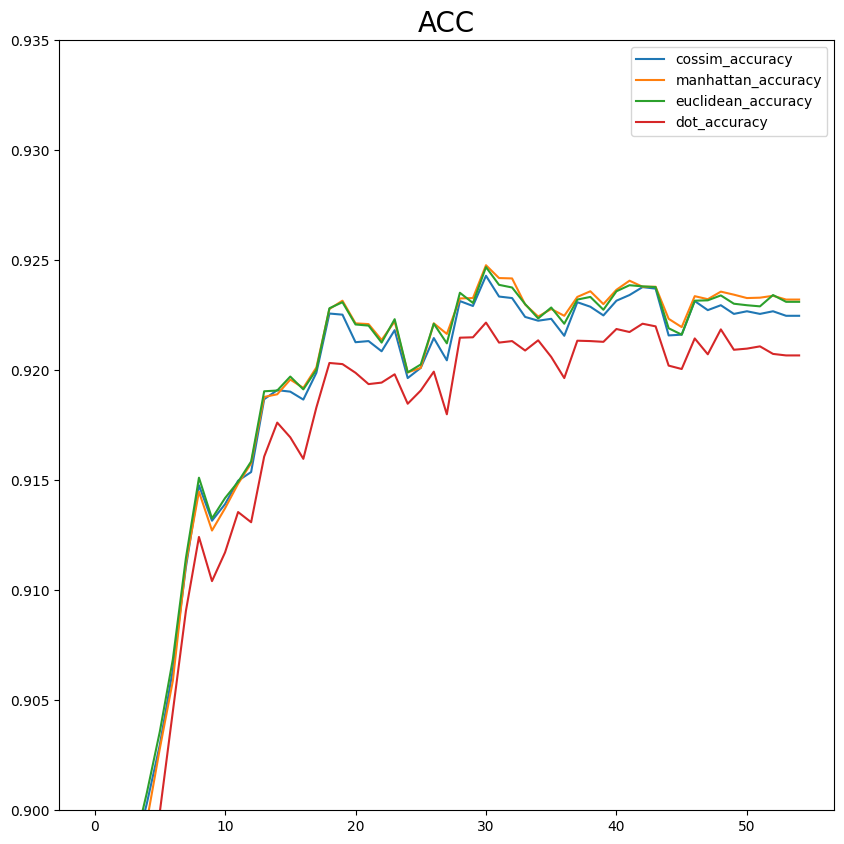

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성

use_col=['cossim_accuracy', 'manhattan_accuracy', 'euclidean_accuracy', 'dot_accuracy']
df_final = data[use_col]

for i in use_col:
  ax.plot(data[i], label=i) ## 선그래프 생성
plt.legend()

plt.ylim([0.9, 0.935])

plt.title('ACC',fontsize=20) ## 타이틀 설정
plt.show()

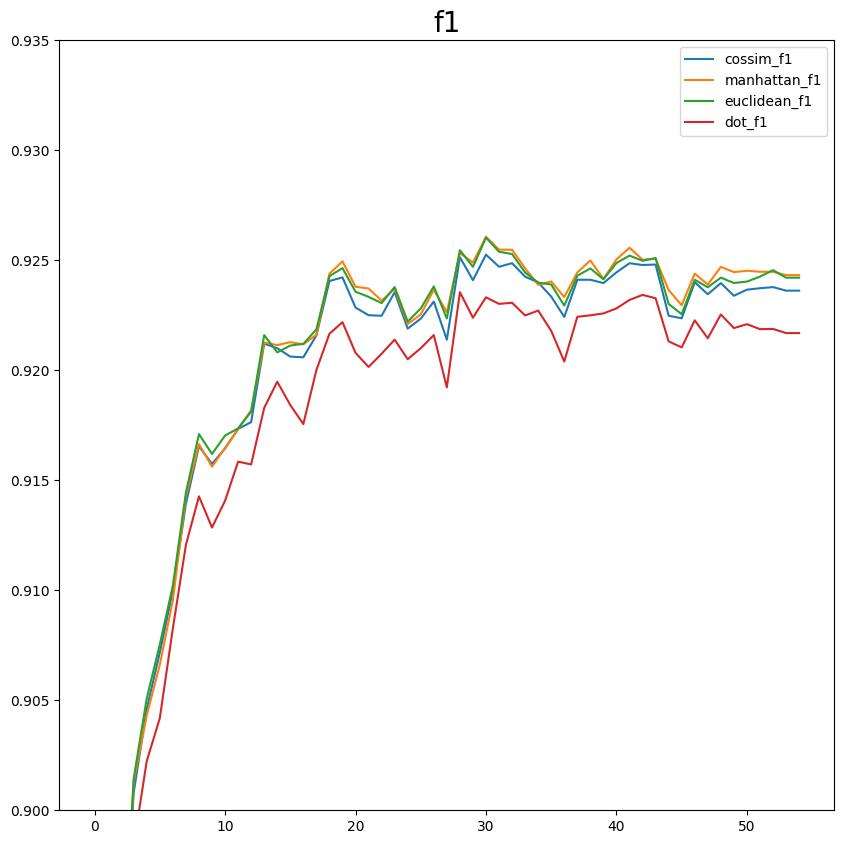

In [ ]:
use_col=['cossim_f1', 'manhattan_f1', 'euclidean_f1', 'dot_f1']
df_final = data[use_col]

fig = plt.figure(figsize=(10,10)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성

for i in use_col:
  ax.plot(df_final[i], label=i) ## 선그래프 생성
plt.legend()

plt.ylim([0.9, 0.935])

plt.title('f1',fontsize=20) ## 타이틀 설정
plt.show()

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/2023_spring_semester/TextMining/tm_teamproject/output/training_sts-klue-roberta-base-2023-06-05_16-53-59/binary_classification_evaluation_sts-test_results.csv')
test.head()

,epoch,steps,cossim_accuracy,cossim_accuracy_threshold,cossim_f1,cossim_precision,cossim_recall,cossim_f1_threshold,cossim_ap,manhattan_accuracy,...,euclidean_recall,euclidean_f1_threshold,euclidean_ap,dot_accuracy,dot_accuracy_threshold,dot_f1,dot_precision,dot_recall,dot_f1_threshold,dot_ap
0,-1,-1,0.921806,0.708118,0.92232,0.91151,0.933388,0.693651,0.954514,0.922931,...,0.930416,10.025051,0.955117,0.919829,116.706833,0.920722,0.906525,0.93537,115.336891,0.948815


## 6. clickbait classification example

In [ ]:
!pip install konlpy

In [ ]:
!pip install sentence_transformers

In [ ]:
!pip install gradio

In [ ]:
!pip install transformers pytorch_lightning==1.4.9
!pip install torchmetrics==0.6.0
!pip install torchtext==0.6.0
!pip install transformers[sentencepiece]

In [5]:
import pandas as pd
import numpy as np
from konlpy.tag import Okt
from string import whitespace, punctuation
import re
import unicodedata
from sentence_transformers import SentenceTransformer, util
import gradio as gr

import pytorch_lightning as pl
import torch

from transformers import PreTrainedTokenizerFast, BartForConditionalGeneration
from transformers import BartForConditionalGeneration, PreTrainedTokenizerFast
from transformers.optimization import get_cosine_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
from konlpy.tag import Okt

# classification


def CleanEnd(text):
    email = re.compile(
        r'[-_0-9a-z]+@[-_0-9a-z]+(?:\.[0-9a-z]+)+', flags=re.IGNORECASE)
    url = re.compile(
        r'(?:https?:\/\/)?[-_0-9a-z]+(?:\.[-_0-9a-z]+)+', flags=re.IGNORECASE)
    etc = re.compile(
        r'\.([^\.]*(?:기자|특파원|교수|작가|대표|논설|고문|주필|부문장|팀장|장관|원장|연구원|이사장|위원|실장|차장|부장|에세이|화백|사설|소장|단장|과장|기획자|큐레이터|저작권|평론가|©|©|ⓒ|\@|\/|=|▶|무단|전재|재배포|금지|\[|\]|\(\))[^\.]*)$')
    bracket = re.compile(r'^((?:\[.+\])|(?:【.+】)|(?:<.+>)|(?:◆.+◆)\s)')

    result = email.sub('', text)
    result = url.sub('', result)
    result = etc.sub('.', result)
    result = bracket.sub('', result).strip()
    return result


def TextFilter(text):
    punct = ''.join([chr for chr in punctuation if chr != '%'])
    filtering = re.compile(f'[{whitespace}{punct}]+')
    onlyText = re.compile(r'[^\% ㄱ-ㅣ가-힣]+')
    result = filtering.sub(' ', text)
    result = onlyText.sub(' ', result).strip()
    result = filtering.sub(' ', result)
    return result


def is_clickbait(title, content, threshold=0.815):
    model = SentenceTransformer('/content/drive/MyDrive/2023_spring_semester/TextMining/tm_teamproject/onlineContrastive-20230611T021137Z-001/onlineContrastive')

    pattern_whitespace = re.compile(f'[{whitespace}]+')
    title = unicodedata.normalize('NFC', re.sub(
        pattern_whitespace, ' ', title)).strip()
    title = CleanEnd(title)
    title = TextFilter(title)

    content = unicodedata.normalize('NFC', re.sub(
        pattern_whitespace, ' ', content)).strip()
    content = CleanEnd(content)
    content = TextFilter(content)

    # Noun Extraction
    okt = Okt()
    title = ' '.join(okt.nouns(title))
    content = ' '.join(okt.nouns(content))

    # Compute embedding
    embeddings1 = model.encode(title, convert_to_tensor=True)
    embeddings2 = model.encode(content, convert_to_tensor=True)

    # Compute cosine-similarities
    cosine_score = util.cos_sim(embeddings1, embeddings2)
    similarity = cosine_score.numpy()[0][0]

    if similarity < threshold:
        return 0, similarity    # clickbait
    else:
        return 1, similarity    # non-clickbait

# Generation
df_train = pd.DataFrame()
df_train['input_text'] = ['1', '2']
df_train['target_text'] = ['1', '2']


def CleanEnd_g(text):
    email = re.compile(
        r'[-_0-9a-z]+@[-_0-9a-z]+(?:\.[0-9a-z]+)+', flags=re.IGNORECASE)
    # url = re.compile(r'(?:https?:\/\/)?[-_0-9a-z]+(?:\.[-_0-9a-z]+)+', flags=re.IGNORECASE)
    # etc = re.compile(r'\.([^\.]*(?:기자|특파원|교수|작가|대표|논설|고문|주필|부문장|팀장|장관|원장|연구원|이사장|위원|실장|차장|부장|에세이|화백|사설|소장|단장|과장|기획자|큐레이터|저작권|평론가|©|©|ⓒ|\@|\/|=|▶|무단|전재|재배포|금지|\[|\]|\(\))[^\.]*)$')
    # bracket = re.compile(r'^((?:\[.+\])|(?:【.+】)|(?:<.+>)|(?:◆.+◆)\s)')

    result = email.sub('', text)
    # result = url.sub('', result)
    # result = etc.sub('.', result)
    # result = bracket.sub('', result).strip()
    return result


class DatasetFromDataframe(Dataset):
    def __init__(self, df, dataset_args):
        self.data = df
        self.max_length = dataset_args['max_length']
        self.tokenizer = dataset_args['tokenizer']
        self.start_token = '<s>'
        self.end_token = '</s>'

    def __len__(self):
        return len(self.data)

    def create_tokens(self, text):
        tokens = self.tokenizer.encode(
            self.start_token + text + self.end_token)

        tokenLength = len(tokens)
        remain = self.max_length - tokenLength

        if remain >= 0:
            tokens = tokens + [self.tokenizer.pad_token_id] * remain
            attention_mask = [1] * tokenLength + [0] * remain
        else:
            tokens = tokens[: self.max_length - 1] + \
                self.tokenizer.encode(self.end_token)
            attention_mask = [1] * self.max_length

        return tokens, attention_mask

    def __getitem__(self, index):
        record = self.data.iloc[index]

        question, answer = record['input_text'], record['target_text']

        input_id, input_mask = self.create_tokens(question)
        output_id, output_mask = self.create_tokens(answer)

        label = output_id[1:(self.max_length + 1)]
        label = label + (self.max_length - len(label)) * [-100]

        return {
            'input_ids': torch.LongTensor(input_id),
            'attention_mask': torch.LongTensor(input_mask),
            'decoder_input_ids': torch.LongTensor(output_id),
            'decoder_attention_mask': torch.LongTensor(output_mask),
            "labels": torch.LongTensor(label)
        }


class OneSourceDataModule(pl.LightningDataModule):
    def __init__(
        self,
        **kwargs
    ):
        super().__init__()

        self.data = kwargs.get('data')
        self.dataset_args = kwargs.get("dataset_args")
        self.batch_size = kwargs.get("batch_size") or 32
        self.train_size = kwargs.get("train_size") or 0.9

    def setup(self, stage=""):
        # trainset, testset = train_test_split(df_train, train_size=self.train_size, shuffle=True)
        self.trainset = DatasetFromDataframe(df_train, self.dataset_args)
        self.testset = DatasetFromDataframe(df_train, self.dataset_args)

    def train_dataloader(self):
        train = DataLoader(
            self.trainset,
            batch_size=self.batch_size
        )
        return train

    def val_dataloader(self):
        val = DataLoader(
            self.testset,
            batch_size=self.batch_size
        )
        return val

    def test_dataloader(self):
        test = DataLoader(
            self.testset,
            batch_size=self.batch_size
        )
        return test


class KoBARTConditionalGeneration(pl.LightningModule):
    def __init__(self, hparams, **kwargs):
        super(KoBARTConditionalGeneration, self).__init__()
        self.hparams.update(hparams)

        self.model = kwargs['model']
        self.tokenizer = kwargs['tokenizer']

        self.model.train()

    def configure_optimizers(self):
        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']

        optimizer_grouped_parameters = [{
            'params': [
                p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
            ],
            'weight_decay': 0.01
        }, {
            'params': [
                p for n, p in param_optimizer if any(nd in n for nd in no_decay)
            ],
            'weight_decay': 0.0
        }]

        optimizer = torch.optim.AdamW(
            optimizer_grouped_parameters,
            lr=self.hparams.lr
        )

        # num_workers = gpus * num_nodes
        data_len = len(self.train_dataloader().dataset)
        print(f'학습 데이터 양: {data_len}')

        num_train_steps = int(
            data_len / self.hparams.batch_size * self.hparams.max_epochs)
        print(f'Step 수: {num_train_steps}')

        num_warmup_steps = int(num_train_steps * self.hparams.warmup_ratio)
        print(f'Warmup Step 수: {num_warmup_steps}')

        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=num_warmup_steps,
            num_training_steps=num_train_steps
        )

        lr_scheduler = {
            'scheduler': scheduler,
            'monitor': 'loss',
            'interval': 'step',
            'frequency': 1
        }

        return [optimizer], [lr_scheduler]

    def forward(self, inputs):
        return self.model(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            decoder_input_ids=inputs['decoder_input_ids'],
            decoder_attention_mask=inputs['decoder_attention_mask'],
            labels=inputs['labels'],
            return_dict=True
        )

    def training_step(self, batch, batch_idx):
        loss = self(batch).loss
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self(batch).loss

    def test(self, text):
        tokens = self.tokenizer.encode("<s>" + text + "</s>")

        tokenLength = len(tokens)
        remain = self.hparams.max_length - tokenLength

        if remain >= 0:
            tokens = tokens + [self.tokenizer.pad_token_id] * remain
            attention_mask = [1] * tokenLength + [0] * remain
        else:
            tokens = tokens[: self.hparams.max_length - 1] + \
                self.tokenizer.encode("</s>")
            attention_mask = [1] * self.hparams.max_length

        tokens = torch.LongTensor([tokens])
        attention_mask = torch.LongTensor([attention_mask])
        self.model = self.model

        result = self.model.generate(
            tokens,
            max_length=self.hparams.max_length,
            attention_mask=attention_mask,
            num_beams=10
        )[0]

        a = self.tokenizer.decode(result)
        return a


def generation(szContent):
    tokenizer = PreTrainedTokenizerFast.from_pretrained("gogamza/kobart-summarization")
    model1 = BartForConditionalGeneration.from_pretrained("gogamza/kobart-summarization")
    if len(szContent) > 500:
        input_ids = tokenizer.encode(szContent[:500], return_tensors="pt")
    else:
        input_ids = tokenizer.encode(szContent, return_tensors="pt")

    summary = model1.generate(
        input_ids=input_ids,
        bos_token_id=model1.config.bos_token_id,
        eos_token_id=model1.config.eos_token_id,
        length_penalty=.3,  # bigger than 1= longer, smaller than 1=shorter summary
        max_length=35,
        min_length=25,
        num_beams=5)
    szSummary = tokenizer.decode(summary[0], skip_special_tokens=True)
    print(szSummary)
    KoBARTModel = BartForConditionalGeneration.from_pretrained('/content/drive/MyDrive/2023_spring_semester/TextMining/tm_teamproject/final2.h5')
    BATCH_SIZE = 32
    MAX_LENGTH = 128
    EPOCHS = 0
    model2 = KoBARTConditionalGeneration({
        "lr": 5e-6,
        "warmup_ratio": 0.1,
        "batch_size": BATCH_SIZE,
        "max_length": MAX_LENGTH,
        "max_epochs": EPOCHS
    },
        tokenizer=tokenizer,
        model=KoBARTModel
    )
    dm = OneSourceDataModule(
        data=df_train,
        batch_size=BATCH_SIZE,
        train_size=0.9,
        dataset_args={
            "tokenizer": tokenizer,
            "max_length": MAX_LENGTH,
        }
    )
    trainer = pl.Trainer(
        max_epochs=EPOCHS,
        gpus=0
    )

    trainer.fit(model2, dm)
    szTitle = model2.test(szSummary)
    df = pd.DataFrame()
    df['newTitle'] = [szTitle]
    df['content'] = [szContent]
    # White space, punctuation removal
    pattern_whitespace = re.compile(f'[{whitespace}]+')
    df['newTitle'] = df.newTitle.fillna('').replace(pattern_whitespace, ' ').map(lambda x: unicodedata.normalize('NFC', x)).str.strip()
    df['newTitle'] = df.newTitle.map(CleanEnd_g)
    df['newTitle'] = df.newTitle.map(TextFilter)
    return df.newTitle[0]


def new_headline(title, content):
    label = is_clickbait(title, content)
    if label[0] == 0:
        return generation(content)
    elif label[0] == 1:
        return '낚시성 기사가 아닙니다.'


In [ ]:
# gradio
with gr.Blocks() as demo1:
    gr.Markdown(
        """
    <h1 align="center">
    clickbait news classifier and new headline generator
    </h1>
    """)

    gr.Markdown(
        """
    뉴스 기사 제목과 본문을 입력하면 낚시성 기사인지 분류하고,
    낚시성 기사이면 새로운 제목을 생성해주는 프로그램입니다.
    """)

    with gr.Row():
        with gr.Column():
            inputs = [gr.Textbox(placeholder="뉴스기사 제목을 입력해주세요", label='headline'),
                      gr.Textbox(
                lines=10, placeholder="뉴스기사 본문을 입력해주세요", label='content')]
            with gr.Row():
                btn = gr.Button("결과 출력")
        with gr.Column():
            output = gr.Text(label='Result')
    btn.click(fn=new_headline, inputs=inputs, outputs=output)

if __name__ == "__main__":
    demo1.launch()
